In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new, predict_r0_multipliers, save_r0_mul
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_r0_multipliers

import yaml

In [3]:
predictions_dict = {}

In [4]:
config_filename = 'weights.yaml'
config = read_config(config_filename)

In [5]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

In [6]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

Performing m1 fit ..
fetching from athenadb...
loading from ../../misc/cache/dataframes_ts_12102020_athena.pkl


KeyError: 0

In [139]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.11041484854503282,
 'I_hosp_ratio': 0.18412356675095481,
 'P_fatal': 0.04695265777024188,
 'T_inc': 4.129856575078595,
 'T_inf': 3.8713622448509386,
 'T_recov': 23.746948208690934,
 'T_recov_fatal': 32.966412370165386,
 'lockdown_R0': 1.5578966277034865}

In [140]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.7296333169987612,
 'I_hosp_ratio': 0.16728643579082375,
 'P_fatal': 0.03646006941104109,
 'T_inc': 4.793661551168644,
 'T_inf': 3.82074424573943,
 'T_recov': 22.937433479513487,
 'T_recov_fatal': 23.858606918668002,
 'lockdown_R0': 0.8295058558883699}

## Loss Dataframes

### M1 Loss DataFrame

In [141]:
predictions_dict['m1']['df_loss']

,train,val
total,18.2059,43.4893
active,203.454,302.406
recovered,18.2255,32.2061
deceased,16.9585,32.9564


### M2 Loss DataFrame

In [142]:
predictions_dict['m2']['df_loss']

,train
total,34.7257
active,130.072
recovered,27.1751
deceased,9.93496


## Sensitivity Plot

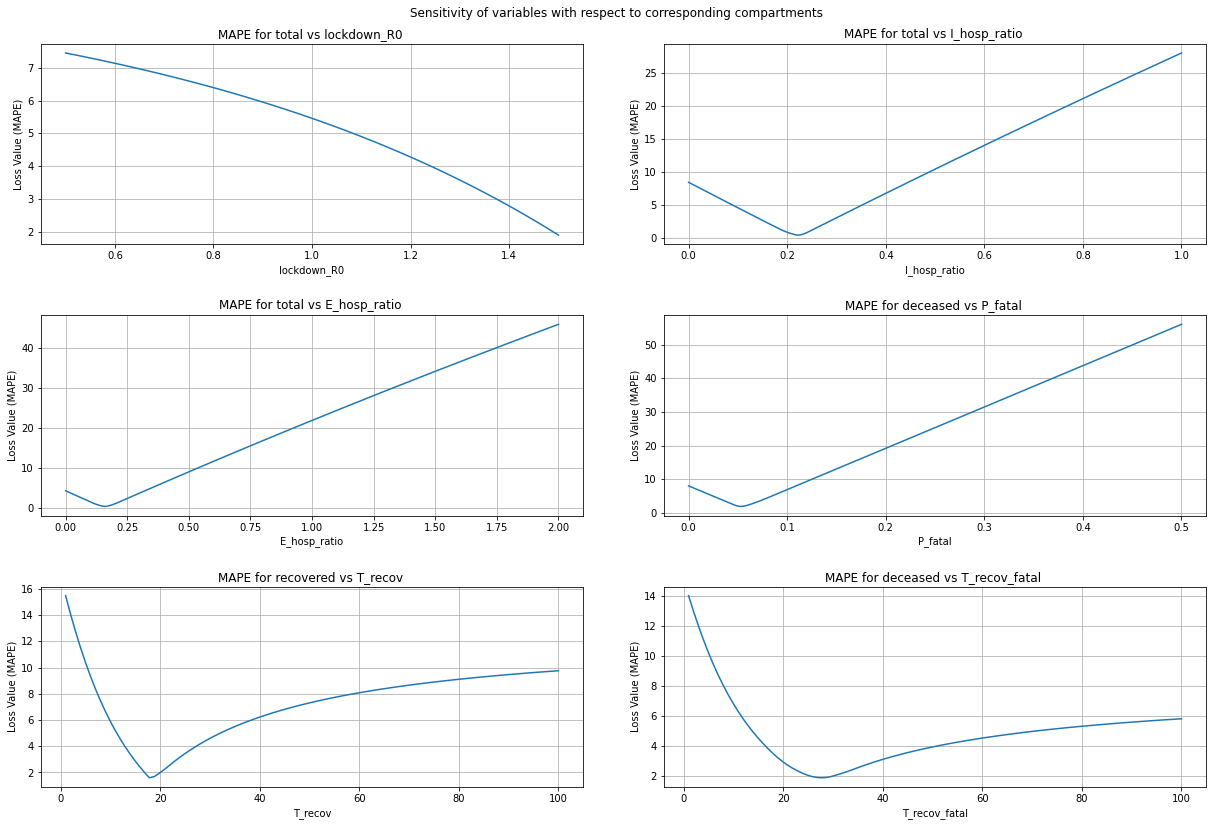

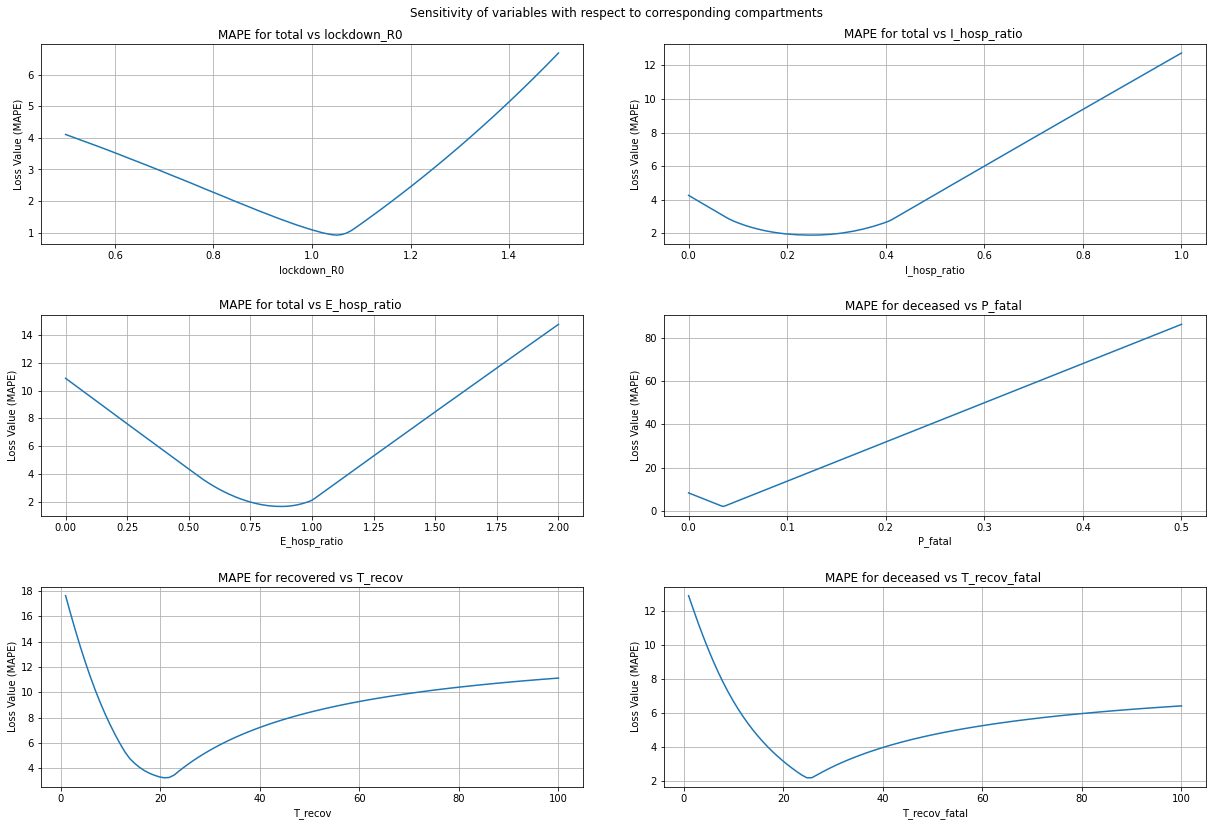

In [143]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

In [144]:
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


[         date        S      E     I  R_recov  R_fatal       C      D  active  \
0  2020-08-26  1243152  14047  3220    18551      701  112820   7506   19252   
1  2020-08-27  1242360  12122  4861    18775      711  113632   7535   19486   
2  2020-08-28  1241322  10779  5832    19305      732  114461   7565   20037   
3  2020-08-29  1240142   9817  6369    19995      760  115317   7597   20755   
4  2020-08-30  1238889   9099  6634    20751      789  116206   7629   21540   
..        ...      ...    ...   ...      ...      ...     ...    ...     ...   
88 2020-11-22  1200034    419   388     6581      267  182195  10112    6848   
89 2020-11-23  1199963    404   374     6394      259  182478  10124    6653   
90 2020-11-24  1199894    390   361     6212      252  182753  10134    6464   
91 2020-11-25  1199828    376   348     6035      245  183020  10145    6280   
92 2020-11-26  1199765    362   335     5862      238  183279  10155    6100   

    recovered  deceased   total  
0   

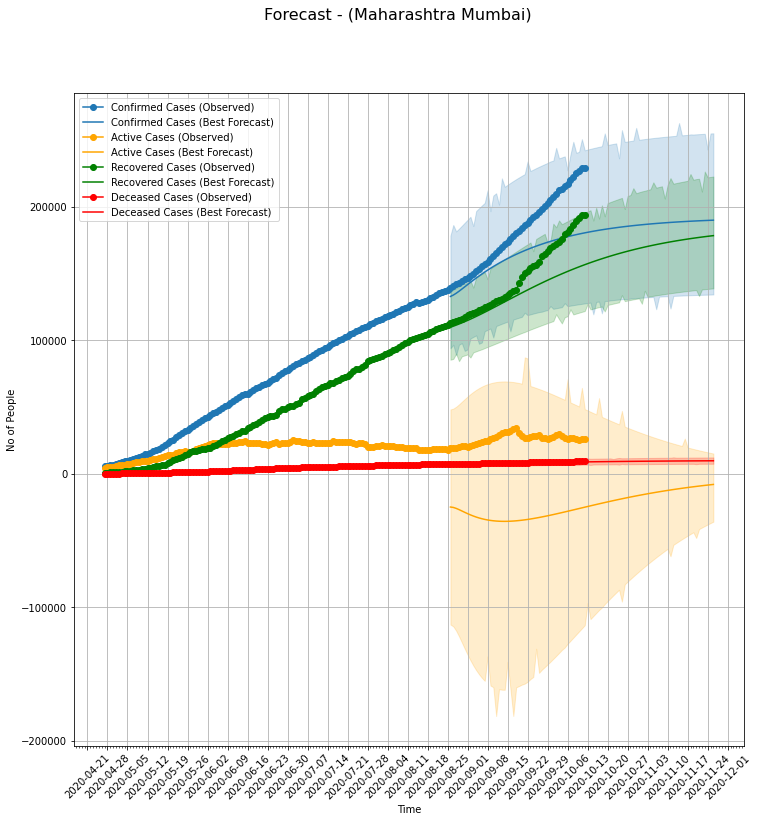

In [145]:
# Predictions plotted are for the most recent train_period days + test_period + forecast_period (no validation_period)
predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 (config['fitting']['data']['dataloading_params']['state'], 
                                                                  config['fitting']['data']['dataloading_params']['district']), 
                                                                 error_bars=True)

In [146]:
predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

4it [00:00, 34.43it/s]getting forecasts ..
200it [00:05, 33.39it/s]


In [147]:
predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

3it [00:00, 29.29it/s]getting forecasts ..
200it [00:05, 36.92it/s]


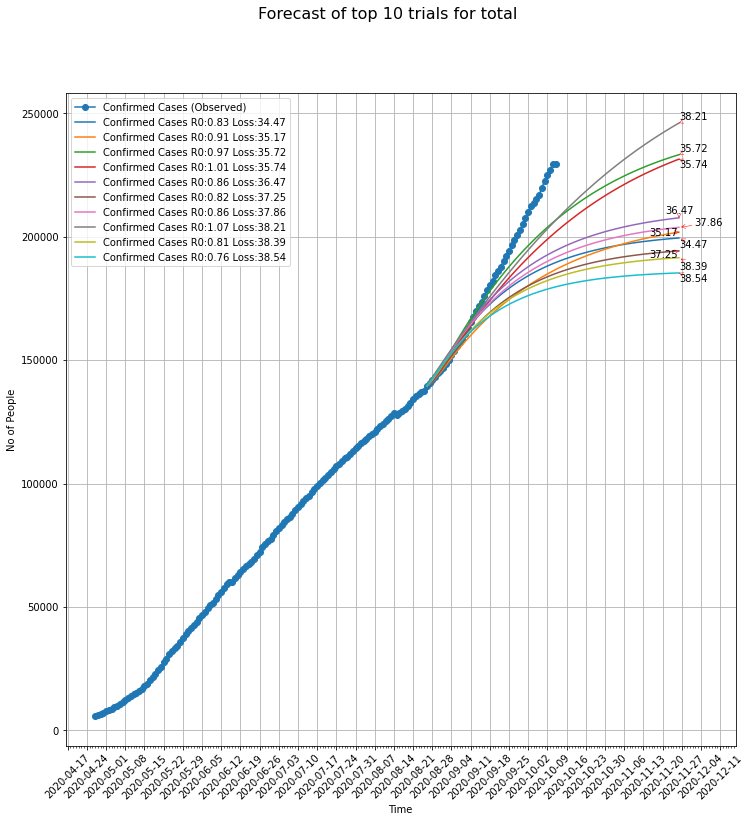

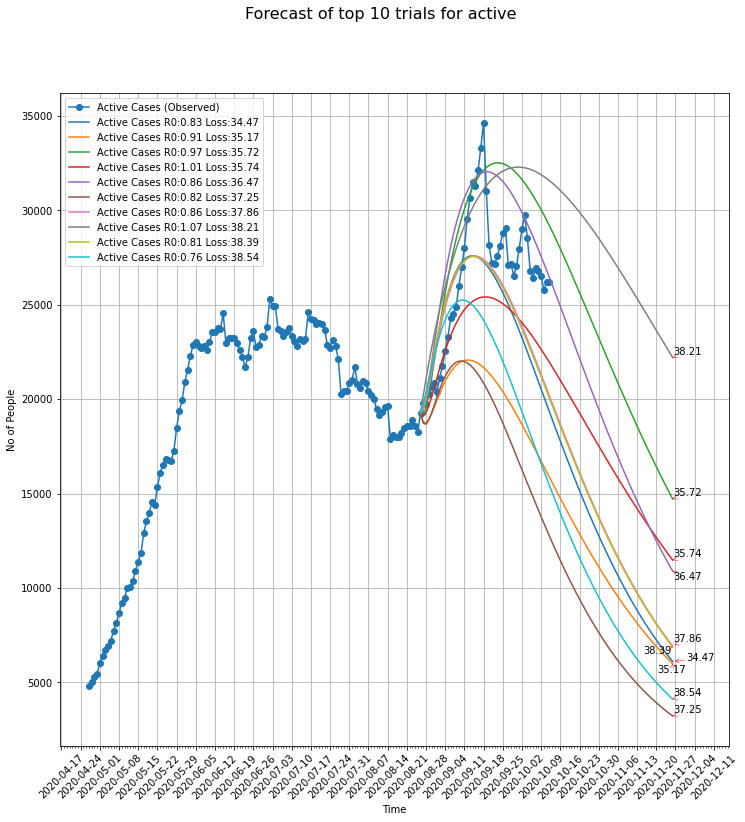

In [148]:
kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])

In [149]:
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [150]:
uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

100%|██████████| 100/100 [00:20<00:00,  4.95trial/s, best loss: 63.99071242588778]


In [151]:
uncertainty.beta_loss

{'active': 187.83175630389903,
 'recovered': 33.431524237771306,
 'deceased': 16.81962785273562,
 'total': 17.879941309145156}

In [152]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [153]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

[         date        S      E     I  R_recov  R_fatal       C      D  active  \
0  2020-08-26  1243152  14047  3220    18551      701  112820   7506   19252   
1  2020-08-27  1242360  12122  4861    18775      711  113632   7535   19486   
2  2020-08-28  1241322  10779  5832    19305      732  114461   7565   20037   
3  2020-08-29  1240142   9817  6369    19995      760  115317   7597   20755   
4  2020-08-30  1238889   9099  6634    20751      789  116206   7629   21540   
..        ...      ...    ...   ...      ...      ...     ...    ...     ...   
88 2020-11-22  1200034    419   388     6581      267  182195  10112    6848   
89 2020-11-23  1199963    404   374     6394      259  182478  10124    6653   
90 2020-11-24  1199894    390   361     6212      252  182753  10134    6464   
91 2020-11-25  1199828    376   348     6035      245  183020  10145    6280   
92 2020-11-26  1199765    362   335     5862      238  183279  10155    6100   

    recovered  deceased   total  
0   

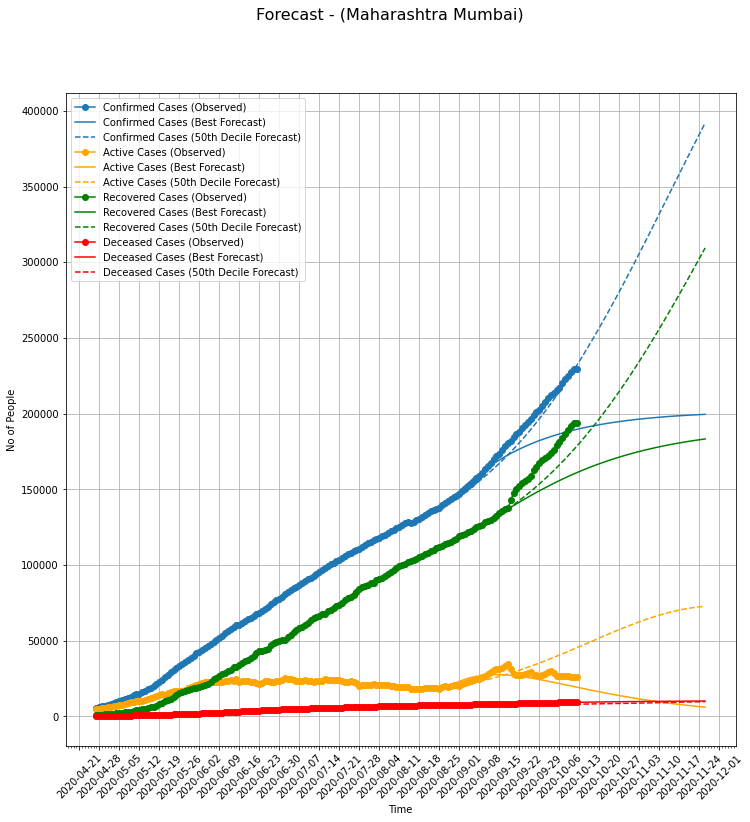

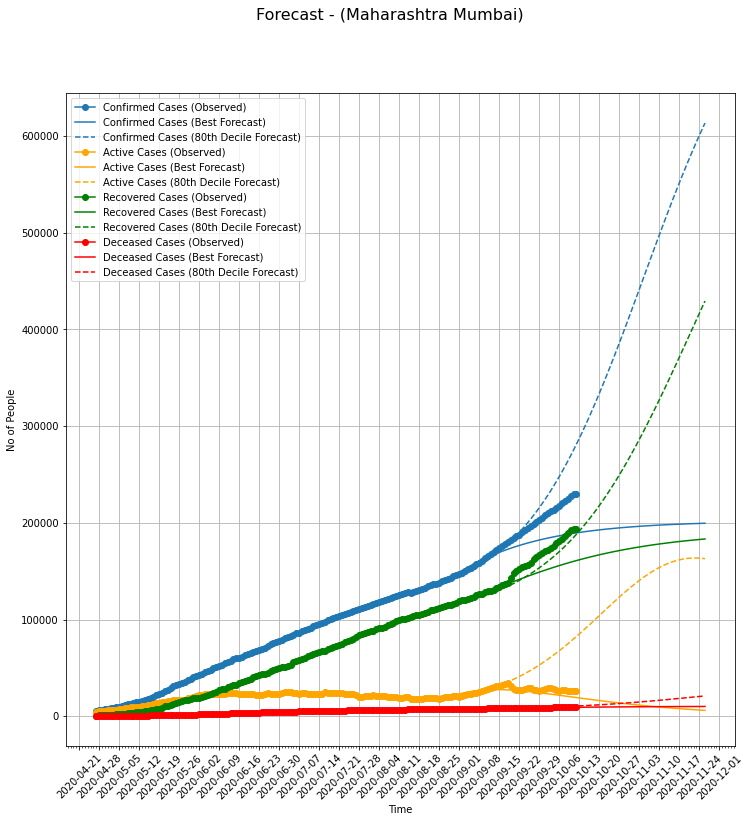

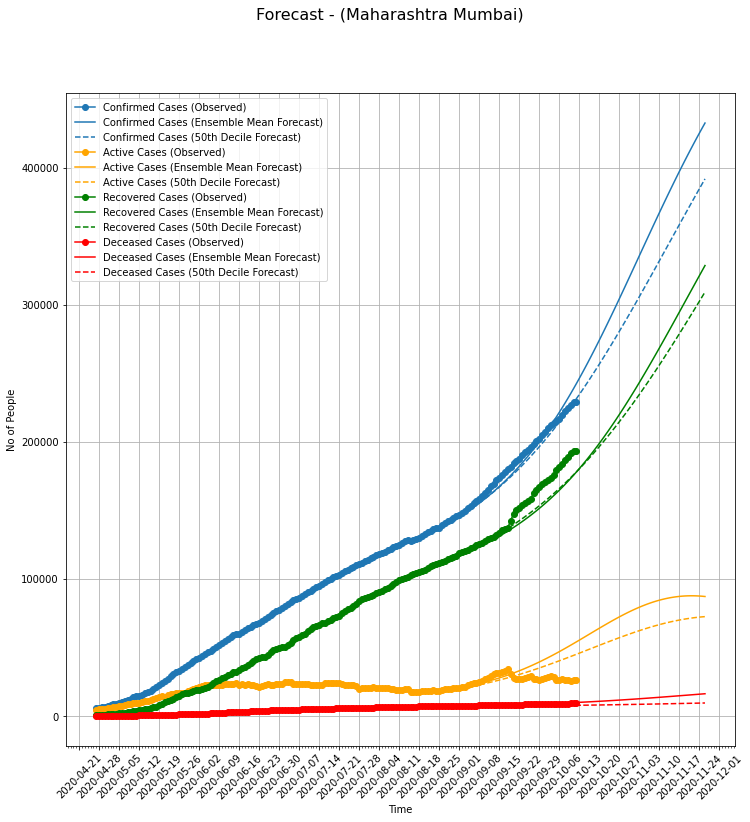

In [154]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

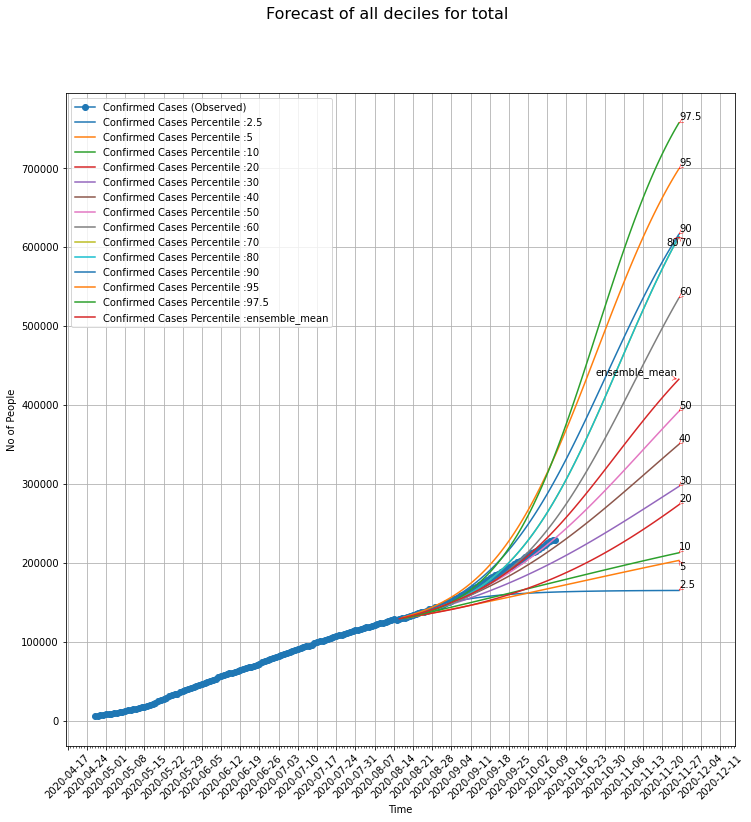

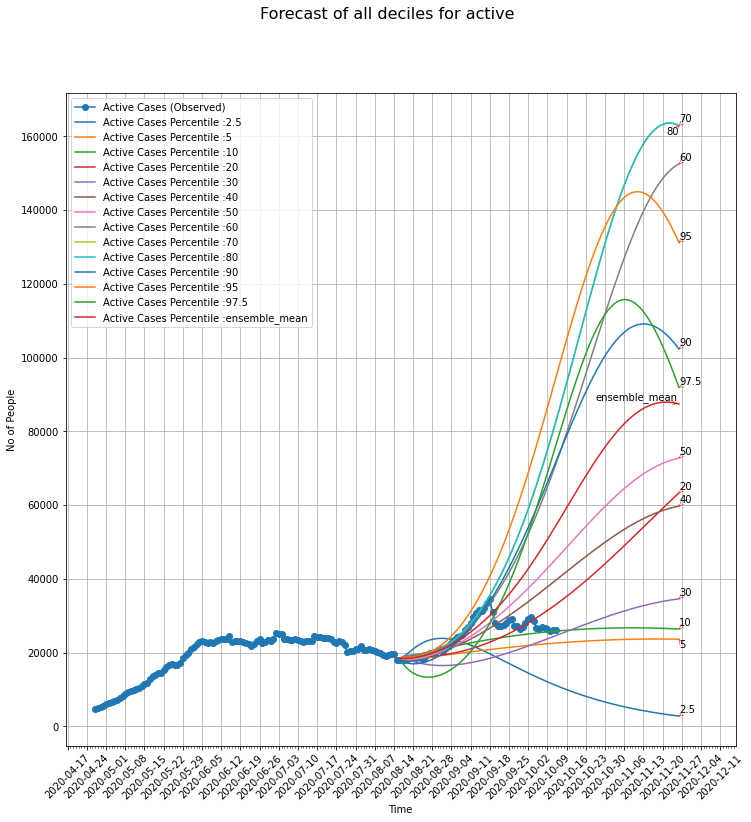

In [155]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## What If Scenarios - R0 Multipliers

getting forecasts ..
getting forecasts ..


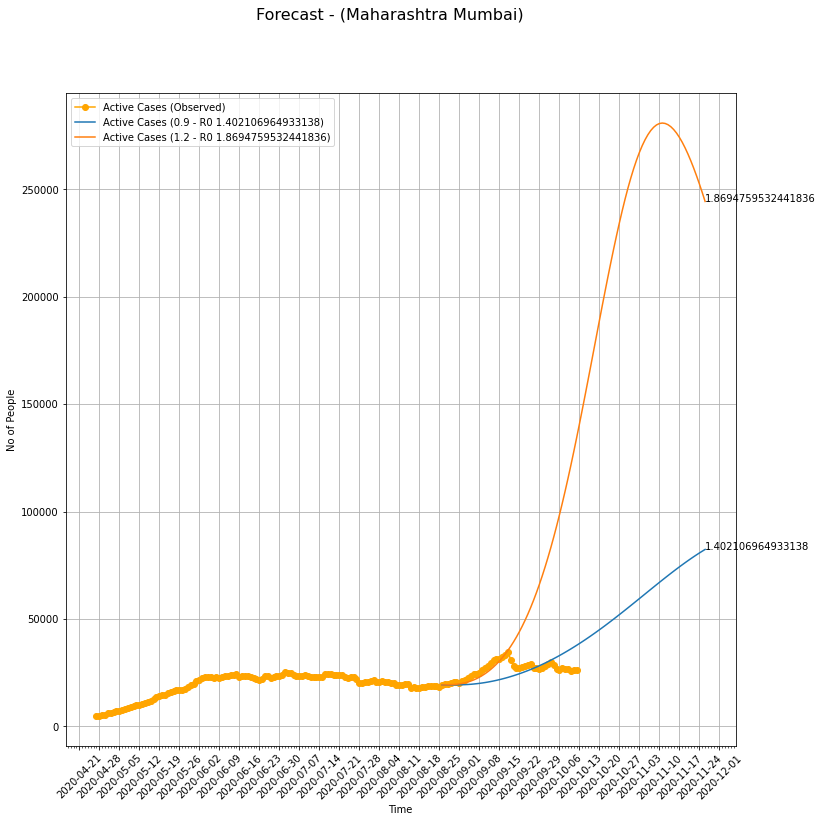

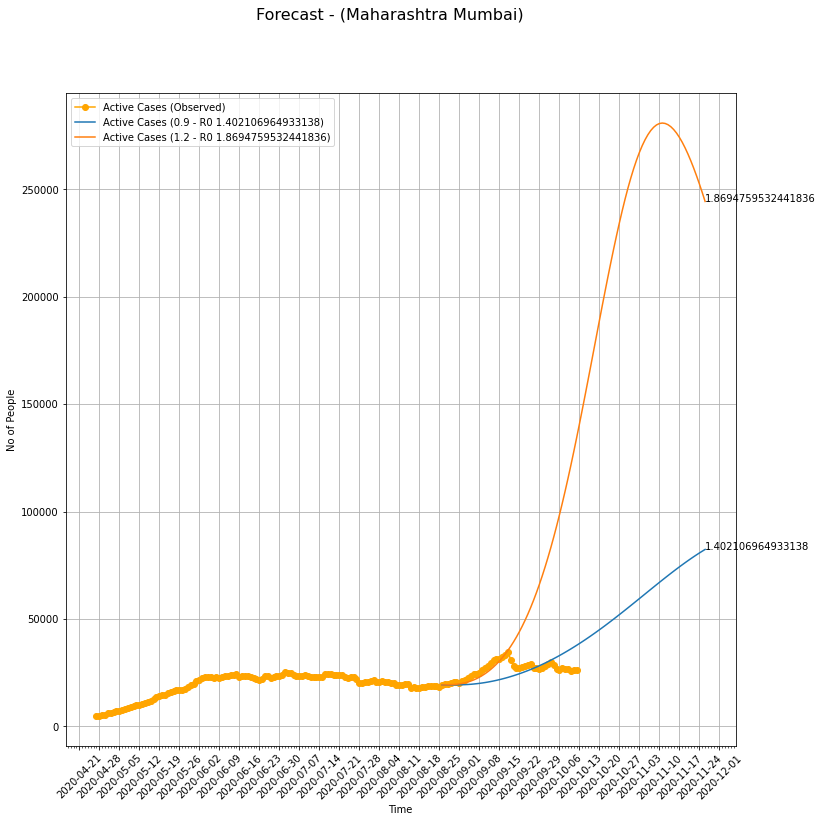

In [156]:
r0_mul_params= predictions_dict['m2']['deciles'][config['what_ifs']['percentile']]['params']
predictions_mul_dict = predict_r0_multipliers(predictions_dict, r0_mul_params, model=config['fitting']['model'],            days=config['forecast']['forecast_days'], multipliers=config['what_ifs']['multipliers'])
plot_r0_multipliers(predictions_dict, None, predictions_mul_dict, None, config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district'])

## Create Report

In [157]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output

In [158]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

In [159]:
#log_wandb(predictions_dict)

## Create All Trials Output

In [160]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

In [161]:
save_r0_mul(predictions_mul_dict, output_folder)

## Experiments

In [162]:
predictions_dict['m1'].keys()

dict_keys(['plots', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'trials', 'data_last_date', 'smoothing_description', 'df_district_unsmoothed', 'run_params', 'trials_processed'])

In [163]:
predictions_dict['m2'].keys()

dict_keys(['plots', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'trials', 'data_last_date', 'smoothing_description', 'df_district_unsmoothed', 'run_params', 'forecasts', 'trials_processed', 'beta', 'beta_loss', 'deciles'])

In [164]:
predictions_dict['m2']['df_district']

,date,state,district,total,active,recovered,deceased,tested,other,daily_cases
0,2020-04-27,Maharashtra,Mumbai,5780,4794,763,223,NaN,NaN,373.0
1,2020-04-28,Maharashtra,Mumbai,6178,5017,908,253,NaN,NaN,398.0
2,2020-04-29,Maharashtra,Mumbai,6658,5260,1114,284,NaN,NaN,480.0
3,2020-04-30,Maharashtra,Mumbai,7080,5422,1349,309,NaN,NaN,422.0
4,2020-05-01,Maharashtra,Mumbai,7836,6040,1476,320,NaN,NaN,756.0
...,...,...,...,...,...,...,...,...,...,...
164,2020-10-08,Maharashtra,Mumbai,222784,26813,186675,9296,1232838.0,430.0,2823.0
165,2020-10-09,Maharashtra,Mumbai,225073,26506,189224,9343,1232838.0,434.0,2289.0
166,2020-10-10,Maharashtra,Mumbai,227276,25789,192096,9391,1232838.0,437.0,2203.0
167,2020-10-11,Maharashtra,Mumbai,229446,26208,193805,9433,1232838.0,441.0,2170.0


In [165]:
from utils.fitting.data_weights import Data_Weights

In [166]:
weights = config['fitting']['data_weights']['weights']

In [167]:
start_date = config['fitting']['data_weights']['start_date']
end_date = config['fitting']['data_weights']['end_date']

In [168]:
df_district = predictions_dict['m1']['df_district']

In [169]:
df_data_weights = Data_Weights.make_weights_df(0, df_district, start_date, end_date, weights)

          date        state district   total  active  recovered  deceased  \
0   2020-04-27  Maharashtra   Mumbai    5780    4793        764       223   
1   2020-04-28  Maharashtra   Mumbai    6177    5015        910       252   
2   2020-04-29  Maharashtra   Mumbai    6657    5258       1116       283   
3   2020-04-30  Maharashtra   Mumbai    7079    5419       1352       308   
4   2020-05-01  Maharashtra   Mumbai    7835    6039       1477       319   
..         ...          ...      ...     ...     ...        ...       ...   
164 2020-10-08  Maharashtra   Mumbai  222784   26813     186675      9296   
165 2020-10-09  Maharashtra   Mumbai  225073   26506     189224      9343   
166 2020-10-10  Maharashtra   Mumbai  227276   25789     192096      9391   
167 2020-10-11  Maharashtra   Mumbai  229446   26208     193805      9433   
168 2020-10-12  Maharashtra   Mumbai  229446   26208     193805      9433   

        tested  other  daily_cases  
0          NaN    NaN        373.0  
1

In [170]:
start_date, end_date, train_period, val_period, test_period = config['fitting']['split'].values()

In [171]:
df_data_weights_train, df_data_weights_val, df_data_weights_test = Data_Weights.implement_split(0, df_data_weights, train_period,val_period, test_period, start_date, end_date)

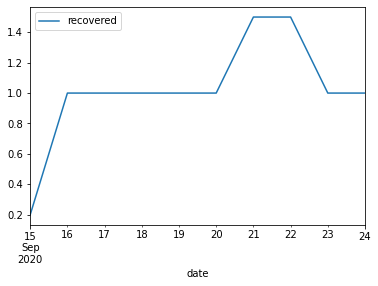

In [172]:
df_data_weights_val.plot(x='date', y='recovered')